# Spatial Data Lab

In [1]:
# pip install geopandas
# pip install tqdm
# pip install pysal

# basic stuff
import os
import pandas as pd
import numpy as np
from random import randint, uniform
from datetime import datetime
from urllib import urlretrieve
from zipfile import ZipFile
import pysal

# geo stuff
import geopandas as gpd
from shapely.geometry import Point
# from ipyleaflet import (Map,
#     Marker,
#     TileLayer, ImageOverlay,
#     Polyline, Polygon, Rectangle, Circle, CircleMarker,
#     GeoJSON,
#     DrawControl
# )

# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# widget stuff
from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

# progress stuff
from tqdm import tqdm_notebook, tqdm_pandas

# turn warnings off
import warnings
warnings.filterwarnings('ignore')

In [2]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [3]:
#check projection are we looking at?
world.crs
#that was informative. you can find out more about projects in geopandas here: http://geopandas.org/projections.html

{'init': u'epsg:4326'}

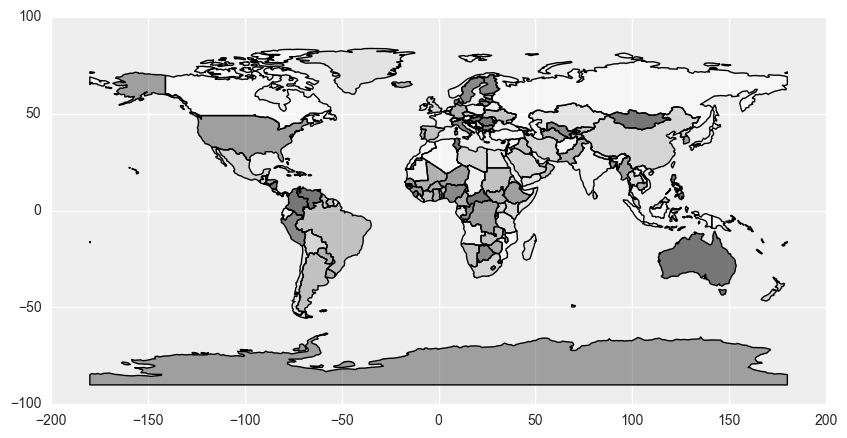

In [4]:
world.plot()

In [5]:
def get_nyc_shape_file(url, filename):

    # download file
    zipped = filename + '.zip'
    urlretrieve('https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile', zipped)
    zipped = os.getcwd() + '/' + zipped

    # unzip file
    to_unzip = ZipFile(zipped, 'r')
    unzipped = os.getcwd() + '/' + filename + '_unzipped'
    to_unzip.extractall(unzipped)
    to_unzip.close()

    # get shape file
    for file in os.listdir(unzipped):
        if file.endswith(".shp"):
            shape_file =  unzipped + '/' + file

    # return full file path
    return shape_file

In [6]:
# get shape file path
shape_file_url = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile'
shape_file_dir = 'nyc_boroughs'
file_path = get_nyc_shape_file(shape_file_url,shape_file_dir)

In [2]:
gdf = gpd.GeoDataFrame.from_file('nyc_boroughs_unzipped')
gdf.head()

,boro_code,boro_name,geometry,shape_area,shape_leng
0,3.0,Brooklyn,(POLYGON ((-73.86706149472118 40.5820879767934...,1.937487e+09,741109.427047
1,4.0,Queens,(POLYGON ((-73.83668274106707 40.5949466970158...,3.044829e+09,895714.759861
2,5.0,Staten Island,(POLYGON ((-74.05050806403247 40.5664220341608...,1.623819e+09,330476.026530
3,1.0,Manhattan,(POLYGON ((-74.01092841268031 40.6844914725429...,6.364538e+08,358410.635285
4,2.0,Bronx,(POLYGON ((-73.89680883223774 40.7958084451597...,1.186816e+09,464081.178241


## NYC Data Component
During the lesson, we looked at each borough of NYC, drew random samples, and assessed whether these samples fell inside each borough, the convex hull of each borough, or the envelope of each borough.

Generate 10,000 samples uniformly across the NYC map. (Note, you're generating both a random X and a random Y in order to get a location on the NYC map, much like we did when we estimated the value of $\pi$ with the "grains of sand.") Also generate the convex hull and envelope of each borough.

In [3]:
def sim_users(n):

    # create datetime range
#     today = datetime.today().strftime("%m/%d/%Y")
#     rng = pd.date_range(today, periods=p, freq=f)

    # get min/max coordinates
    min_x, min_y = gdf['geometry'].bounds.ix[:,:2].min()
    max_x, max_y = gdf['geometry'].bounds.ix[:,2:].max()

    # iterate over time datetime range and create user list
    sim_user_list = []
#     for ts in tqdm_notebook(rng, desc='Progress', leave=True):
    for j in xrange(n):
        x = uniform(min_x, max_x)
        y = uniform(min_y, max_y)
        point = Point(x, y)
#         gender = randint(0, 1)
        sim_user_list.append([x, y, point])

    # return dataframe
    sim_user_df = pd.DataFrame(sim_user_list, columns=['x', 'y', 'point'])
    return sim_user_df

# simulate user data
sim_data = sim_users(10000)
sim_data.head()

,x,y,point
0,-74.155508,40.741718,POINT (-74.15550778072176 40.74171772675665)
1,-73.937935,40.520653,POINT (-73.93793460080518 40.52065262743917)
2,-73.722661,40.642042,POINT (-73.7226607507065 40.642041701513)
3,-74.237555,40.802559,POINT (-74.23755499818024 40.80255893062981)
4,-73.861072,40.626581,POINT (-73.86107242227165 40.62658054511055)


In [4]:
#convex hulls
hulls = gdf['geometry'].convex_hull
#envelope
envelope = gpd.GeoSeries(hulls.envelope)

In this part, we'll quantify efficiency. While timing your code, check how long it takes for your computer to check:

- Whether or not each sample falls in the true geographic boroughs.
- Whether or not each sample falls in the convex hulls of the boroughs.
- Whether or not each sample falls in the envelopes of the boroughs.

(Check the linear algebra lesson on computational efficiency for commands for timing code.)

Report these numbers, as well as how much more efficient (percentage-wise) envelopes and convex hulls are relative to the true geographies.

In [5]:
import time

start = time.time()
sim_data['contains_1'] = sim_data['point'].map(lambda x: True if gdf.contains(x).any()==True else False)
end = time.time()
print(end - start)

127.024283886


In [6]:
start = time.time()
sim_data['contains_2'] = sim_data['point'].map(lambda x: True if hulls.contains(x).any()==True else False)
end = time.time()
print(end - start)

2.56148505211


In [7]:
start = time.time()
sim_data['contains_3'] = sim_data['point'].map(lambda x: True if envelope.contains(x).any()==True else False)
end = time.time()
print(end - start)

1.61462688446


Obviously there's a trade-off here. Check how many samples lie in the actual geographies, the convex hulls, and the envelopes.

Report the following:

- A confusion matrix comparing convex hulls and actual geographies. (i.e. actual geographies are the true counts; convex hulls are predicted counts)
- A confusion matrix comparing envelopes and actual geographies.
- The accuracy, sensitivity, and specificity from each of the confusion matrices above.
- A paragraph summarizing your findings.

In [8]:
from sklearn.metrics import confusion_matrix, classification_report

In [9]:
confusion_matrix(sim_data['contains_1'], sim_data['contains_2']) #hulls

array([[5358, 1000],
       [   0, 3642]])

In [10]:
confusion_matrix(sim_data['contains_1'], sim_data['contains_3']) #envelopes

array([[3661, 2697],
       [   0, 3642]])

Based on the confusion matrices, they both actively capture everything inside the actual geometry. They're less accurate, however (there are a lot of points outside the geometry), and the envelope does worse (probably because it's less blobby than the convex hull). 

In [12]:
print classification_report(sim_data['contains_1'], sim_data['contains_2'])

             precision    recall  f1-score   support

      False       1.00      0.84      0.91      6358
       True       0.78      1.00      0.88      3642

avg / total       0.92      0.90      0.90     10000



In [13]:
print classification_report(sim_data['contains_1'], sim_data['contains_3'])

             precision    recall  f1-score   support

      False       1.00      0.58      0.73      6358
       True       0.57      1.00      0.73      3642

avg / total       0.85      0.73      0.73     10000



## Project 5 Component
Pivoting to Project 5, take the data for this project. Generate a map of the world with each country shaded based on the number of terror attacks that occur in each country. (Warning: Some data munging is likely necessary here.)

Suppose I want to forecast the number of terror attacks by country. Would this process be described as areal, geostatistical, or point pattern?

Build a widget that will put dots on the map for the location of each terror attack by year. Depending on how precisely you wish to identify the location of the terror attack, you may use the centroid of a country if you'd like. (Note: Using the centroid may cause multiple dots to overlap; people often use a [random jitter](https://www.dataplusscience.com/TableauJitter.html) to help with this. While not required for this lab, consider random jitter as a bonus!)

Suppose I want to predict the precise location of terror attacks. Would this process be described as areal, geostatistical, or point pattern?

### If you're happy with the results here, you should consider including these in your presentations next week!